<a href="https://colab.research.google.com/github/arjoca/RHDocentes/blob/main/Copy_of_RHDocentes_Converge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RHDocentes - fevereiro 2022

**Notebook 3** - Convergência (Correção das assimetrias)

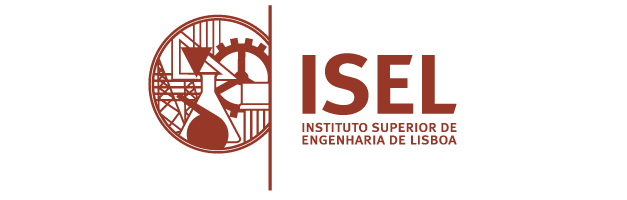

Estudo organizado em 3 notebooks:
*   [O primeiro](https://github.com/arjoca/RHDocentes/blob/main/RHDocentes_Fotografia.ipynb) - Fotografia do ISEL hoje (Assimetrias) 
*   [O anterior](https://github.com/arjoca/RHDocentes/blob/main/RHDocentes_Futuro.ipynb) - Olhar para o Futuro (Dinâmica de aposentações)
*   **Este notebook** - Convergência (Correção das assimetrias)

# Fontes de informação

*   Ficheiro "Afetacao_Financeira_ADs_Cursos_2021_v01.xlsx"
*   Ficheiro "RAIDES_0.xlsx"

Informação que depois de filtrada e anonimizada deu origem aos dados guardados no ficheiro [clean_data.xlsx](https://github.com/arjoca/RHDocentes/blob/main/clean_data.xlsx), usados neste estudo.

# Preparação

## Importação de módulos e leitura de dados

In [1]:
# Instalação de módulos
!pip install kora -q
!pip install -U kaleido

     |████████████████████████████████| 57 kB 970 kB/s 
     |████████████████████████████████| 56 kB 4.3 MB/s 
     |████████████████████████████████| 79.9 MB 107 kB/s 


In [30]:
# Importação de módulos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from ipywidgets import widgets, interact, fixed
from IPython.display import Image

In [3]:
# Leitura de dados
base_url = 'https://raw.githubusercontent.com/arjoca/RHDocentes/main/data/'
docentes = pd.read_csv(base_url + 'docentes.csv', encoding= 'unicode_escape', 
                       parse_dates=['Data Nascimento'], infer_datetime_format=True)
alunos_per_curso = pd.read_csv(base_url + 'alunos.csv', encoding= 'unicode_escape', index_col=0)
horas = pd.read_csv(base_url + 'horas.csv', encoding= 'unicode_escape', index_col=0)

## Inicializações

In [4]:
# Designações dos cursos e departamentos
LISTA_DEPTS = sorted(docentes['Departamento'].unique())
LISTA_CURSOS = sorted(alunos_per_curso.index.unique())

In [5]:
# Designações das categorias de docentes
cat_prof_coord = ['Prof. Coordenador', 'Prof. Coordenador c/ Agreg. ', 'Professor Coordenador Principal']
cat_convidado = ['Assistente Convidado', 'Professor Adjunto Convidado']
cat_adjunto = ['Professor Adjunto']
cat_assistente = ['Assistente do 2. Trienio', 'Assistente', 'Equiparado Assistente 2. Trienio']
cat_monitor = ['Monitor']
cat_quadro = cat_prof_coord + cat_adjunto
cat_todas = cat_quadro + cat_convidado + cat_assistente + cat_monitor

In [6]:
# Horas de contacto usadas para determinar relações entre cursos e departamentos
horas_per_curso = horas.sum(axis=1)
pesos_dept_per_curso = horas.T / horas_per_curso

# Alunos por departamento
alunos_per_dept = pd.DataFrame(np.dot(pesos_dept_per_curso, alunos_per_curso),
                              index=pesos_dept_per_curso.index, columns=['Alunos'])
alunos_per_dept = alunos_per_dept['Alunos']
alunos_per_dept.name = ''
alunos_per_dept = alunos_per_dept.sort_index()

In [7]:
# Números globais
alunos_per_eti_isel = alunos_per_curso.sum().sum() / docentes['ETI'].sum()
eti_per_dept = docentes.groupby(['Departamento'])['ETI'].sum()

In [8]:
# VIANA (Valor Ideal Atendendo ao Número de Alunos)
viana = alunos_per_dept / alunos_per_eti_isel
fana = viana - eti_per_dept

## Definição de funções

In [9]:
# Filtragem de docentes atendendo à sua idade de aposentação 
def aposentados_e_ativos(df, ano, idade_reforma):
  idade = (datetime(ano, 1, 1) - df['Data Nascimento'])/timedelta(days=365.25)
  aposentados = df[idade > idade_reforma]
  ativos = df.drop(index=aposentados.index)
  return aposentados, ativos

In [10]:
# Filtragem de docentes atendendo à sua categoria
def docentes_per_categoria(df, categoria):
  s = df.groupby(['Departamento', 'Categoria'])['ETI'].sum()
  s = s.loc[(slice(None), categoria)].droplevel(level=1)
  s = s.groupby(s.index).sum()
  s = pd.Series(s, index=LISTA_DEPTS)
  return s.fillna(0)

# Correção de assimetrias

## Bolo a distribuir

## Três métodos de distribuição

In [11]:
# Função auxiliar para determinar quanto falta para o target
def how_many_to_target(target, numerator, denominator):
  s = denominator * target - numerator
  s.clip(lower=0, inplace=True)
  return s

In [85]:
# METHOD 1 - Linear mapping
def linear_map(target, cake, numerator, denominator):
  s = how_many_to_target(target, numerator, denominator)
  return s / s.sum() * cake 

In [119]:
# METHOD 2 - D'Hondt
def method_hondt(target, cake, numerator, denominator):
  s = how_many_to_target(target, numerator, denominator)
  list_of_series = [s/i for i in range(1, cake+1)]
  df = pd.concat(list_of_series, axis=1)
  vals = np.sort(np.ravel(df.to_numpy(copy=True)))[-1::-1]
  df1 = pd.DataFrame(index=LISTA_DEPTS)
  for i,v in enumerate(vals[:cake]):
    ix = df[df==v].stack().index.get_level_values(0)
    df1.loc[ix, i+1] = 1
  df = df >= vals[cake-1]
  sns.heatmap(df1, cbar=False, linewidths=2, linecolor='grey')
  return df.sum(axis=1)

In [63]:
# METHOD 3 - One step iteration
def step_by_step(cake, numerator, denominator):
  df = pd.DataFrame(index=LISTA_DEPTS)
  num = numerator
  den = denominator
  for i in range(cake):
    ratio = num / den
    ix = ratio.idxmin()
    num[ix] += 1
    df.loc[ix,i+1] = 1
  sns.heatmap(df, cbar=False, linewidths=2, linecolor='grey')
  return df.sum(axis=1)

## Simulação

In [47]:
import seaborn as sns

In [120]:
@interact(cake=(2,26,2), target=(0.2,0.5,0.05), ano=(2022,2030,1), 
          reforma=(67,70,1), corrige_fana=True, method=['linear','hondt','step_by_step'])
def fun(cake=16, target=0.25, ano=2022, reforma=70, corrige_fana=True, method='linear'):
  _, ativos = aposentados_e_ativos(docentes, ano, reforma)
  numerator = docentes_per_categoria(ativos, cat_prof_coord)
  denominator = docentes_per_categoria(ativos, cat_todas)
  if corrige_fana:
    denominator += fana
  if method == 'linear':
    s = linear_map(target, cake, numerator, denominator)
  elif method == 'hondt':
    s = method_hondt(target, cake, numerator, denominator)
  elif method == 'step_by_step':
    s = step_by_step(cake, numerator, denominator)
  else: print('ERRO!')
  
  print(s)
  fig, ax = plt.subplots(1, 1, figsize=(12,5))
  s.name=''
  s.plot(kind='bar', ax=ax, table=np.round(s,1).to_frame().T)
  title1 = f'Distribui {cake} vagas - método={method}, '
  title2 = ''
  if method != 'step_by_step':
    title2 += f'target= {target}, '
  title3 = f'corrige_fana={corrige_fana}, ano={ano}, idade_reforma={reforma}'
  ax.set_title(title1 + title2 + title3)
  ax.xaxis.set_visible(False)
  fig.savefig('temp_image.png')

interactive(children=(IntSlider(value=16, description='cake', max=26, min=2, step=2), FloatSlider(value=0.25, …

In [17]:
d1 = pd.DataFrame(np.random.randn(3,5))
d2 = d1 > 0

In [18]:
d1

,0,1,2,3,4
0,0.164556,-1.172058,1.141307,-0.763675,0.160376
1,-0.492619,-0.863654,1.350416,0.703941,-0.018390
2,0.112082,0.033757,1.639785,-0.888475,-1.124756


In [19]:
d2

,0,1,2,3,4
0,True,False,True,False,True
1,False,False,True,True,False
2,True,True,True,False,False


In [20]:
d3 = d1 * d2

In [21]:
sorted(d3.values.flatten())[::-1]

[1.6397852318999873,
 1.3504157860648838,
 1.1413068752472457,
 0.7039411607769974,
 0.16455616780581764,
 0.160376430254884,
 0.11208209616660797,
 0.03375657266174054,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0]

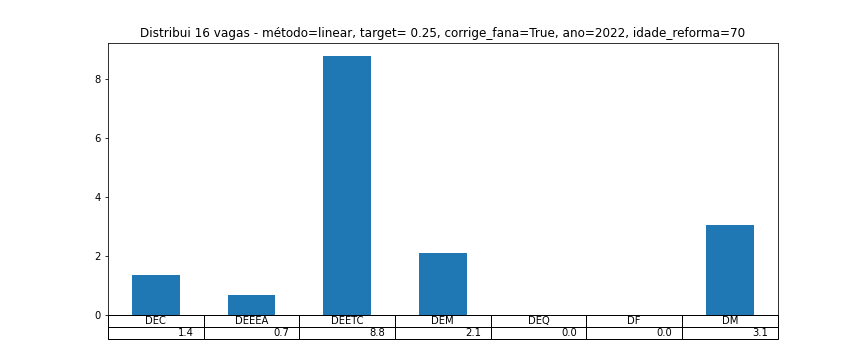

In [22]:
Image('temp_image.png')

In [23]:
#antes (com e sem fana)
numerator = docentes_per_categoria(docentes, cat_prof_coord)
denominator = docentes_per_categoria(docentes, cat_todas)

In [24]:
#depois
s = step_by_step(16, numerator, denominator)
numerator += s

{'DEC': [2, 7, 12], 'DEEEA': [15], 'DEETC': [3, 5, 6, 9, 10, 13, 14], 'DEM': [], 'DEQ': [], 'DF': [], 'DM': [1, 4, 8, 11, 16]}


In [25]:
numerator

DEC      11.0
DEEEA     9.0
DEETC    26.0
DEM      10.0
DEQ       8.0
DF        7.0
DM       15.0
Name: ETI, dtype: float64

In [26]:
numerator

DEC      11.0
DEEEA     9.0
DEETC    26.0
DEM      10.0
DEQ       8.0
DF        7.0
DM       15.0
Name: ETI, dtype: float64

In [27]:
# Calcular entropia antes e depois e ter a diferença como critério